In [23]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from matplotlib import pyplot as plt
from numpy import mean
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, auc, f1_score, precision_score,
                             recall_score, roc_auc_score, silhouette_score)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold,
                                     ShuffleSplit, StratifiedShuffleSplit,
                                     cross_val_score)

In [2]:
IMAGES_PATH = "Image"

In [4]:
def concat_two_df_and_drop_same_column_in_df2(DF1, DF2):
    display(DF1.head(1))
    display(DF2.head(1))
    DF2.drop(DF2.columns[DF2.columns.isin(DF1.columns)],axis=1,inplace=True)
#     DF1.drop(DF1.columns[DF1.columns.isin(DF2.columns)],axis=1,inplace=True)
    result = pd.concat([DF1, DF2], axis=1)
    display(result.head(1))
    return result
def count_list_val(arr):
    values, counts = np.unique(arr, return_counts=True)
    print(values, counts)

In [25]:
four_time = pd.read_csv("CSV/four_time.csv")
v_value = pd.read_csv("CSV/v_value.csv")
mic = pd.read_csv("CSV/mic.csv")
dwt_distance = pd.read_csv("CSV/sdtw_day_score_df.csv")
smart_meter = pd.read_csv("smart_meter.csv")

In [30]:
fdi = pd.read_csv("CSV/FDI.csv")
fdi_4225 = pd.read_csv("CSV/FDI_4225.csv")

In [7]:
result = concat_two_df_and_drop_same_column_in_df2(fdi, v_value)
result = concat_two_df_and_drop_same_column_in_df2(result, four_time)
result = concat_two_df_and_drop_same_column_in_df2(result, mic)
result = concat_two_df_and_drop_same_column_in_df2(result, dwt_distance)
result.columns

,MeterID,Day,FDI
0,1236,2009-07-15,1.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,5212,2010-12-31,True,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,overnight,breakfast,daytime,evening
0,1236,2009-07-15,True,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,mic
0,1236,2009-07-15,True,0.624128


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128


,MeterID,Day,FDI,meter_dtw,meter_sdtw
0,1236,2009-07-15,True,2.283294,-68.276715


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic,meter_dtw,meter_sdtw
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128,2.283294,-68.276715


Index(['MeterID', 'Day', 'FDI', 'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2',
       'Cmin1', 'overnight', 'breakfast', 'daytime', 'evening', 'mic',
       'meter_dtw', 'meter_sdtw'],
      dtype='object')

In [18]:
result = result.drop(['Day', 'MeterID', 'FDI'], axis=1)
t = np.array(result).reshape(4225, -1)
len(t[0])

In [64]:
result.columns

Index(['Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'overnight',
       'breakfast', 'daytime', 'evening', 'mic', 'meter_dtw', 'meter_sdtw'],
      dtype='object')

In [31]:
count_list_val(fdi_4225)

[0 1] [3805  420]


In [20]:
df = pd.DataFrame(t)

In [39]:
partition = 422*6
evaluation = 422*2
total = 4225

In [103]:
def train_model(X, Y, score = False, split_num = 3, return_model=False ):
    

    partition = 422*8*530
    evaluation = 422*1*530
    total = 4225

    round = 1
    average_score = {}
    average_score["precision_score"] = 0
    average_score["recall_score"] = 0
    average_score["accuracy_score"] = 0
    average_score["roc_auc_score"] = 0
    average_score["f1_score"] = 0

    X_train = X[:total]
    y_train = Y[:total]

    sss = StratifiedShuffleSplit(n_splits=split_num, test_size=0.4, random_state=1)
    for train_index, test_index in sss.split(X_train, y_train):
#         test_index = np.concatenate((np.array(test_index), np.array(X[total-(partition+evaluation): total].index)))
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = np.array(Y.iloc[train_index]).reshape(-1) , np.array(Y.iloc[test_index]).reshape(-1)

        model = XGBClassifier(scale_pos_weight=10, use_label_encoder=False)
        model.fit(X_train, Y_train)
        y_hat = model.predict(X_test)
        average_score["precision_score"] += precision_score(Y_test, y_hat)
        average_score["recall_score"] += recall_score(Y_test, y_hat)
        average_score["accuracy_score"] += accuracy_score(Y_test, y_hat)
        average_score["roc_auc_score"] += roc_auc_score(Y_test, y_hat)
        average_score["f1_score"] += f1_score(Y_test, y_hat)

        if score:
            print("round: " + str(round))
            print("precision score: " + str(precision_score(Y_test, y_hat)))
            print("recall_score: " + str(recall_score(Y_test, y_hat)))
            print("accuracy_score: " + str(accuracy_score(Y_test, y_hat)))
            print("roc_auc_score: " + str(roc_auc_score(Y_test, y_hat)))
            print("f1_score: " + str(f1_score(Y_test, y_hat)))
            print()

        round += 1
    for key, score in average_score.items():
        average_score[key] = score / split_num
        print("average_" + key + ": " + str(average_score[key]))
    if return_model==True:
        return model, average_score
    return average_score

def get_permutation_importance(model, X_val, y_val, title=None, origin=False, save=False):
    
    if save_fig == True and title == None:
        raise NameError('Please type the title for the chart to save')
        
    r = permutation_importance(model, X_val, y_val, n_repeats=1, random_state=0)
    four_time_importance = sum(r.importances_mean[:3])
    mic_importance = r.importances_mean[10]
    v_value_importance = sum(r.importances_mean[4:10])
    dtw_importance = r.importances_mean[11]
    sdtw_importance = r.importances_mean[12]
    if origin == True:
        print('include origin data')
        origin_importance = sum(r.importances_mean[13:])
        importance = { "four_time": four_time_importance, "mic": mic_importance, "v_value": v_value_importance,
                  "dtw": dtw_importance, "sdtw": sdtw_importance, 'origin':origin_importance}
    else:
        print('no origin data')
        importance = { "four_time": four_time_importance, "mic": mic_importance, "v_value": v_value_importance, "dtw": dtw_importance, "sdtw": sdtw_importance}
    
    importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))
    
    y_label = list(importance.keys())
    y_pos = np.arange(len(importance))

    plt.rcdefaults()
    fig, ax = plt.subplots()

    ax.barh(y_pos, list(importance.values()), align='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_label)

    ax.set_xlabel('Importance Mean')
    ax.set_title('Permutation importance')
    
    if save == True:
        save_fig('Permutation importance: '+ title)
        
    return r

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, image_path = IMAGES_PATH):
    path = os.path.join(image_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_importance(importance):
    importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))
    
    y_label = list(importance.keys())
    y_pos = np.arange(len(importance))

    plt.rcdefaults()
    fig, ax = plt.subplots()

    ax.barh(y_pos, list(importance.values()), align='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_label)

    ax.set_xlabel('Importance Mean')
    ax.set_title('Permutation importance')

In [93]:
# 6:4 and seperate train and test dataset
# 13 features
model, score = train_model(df, fdi_4225 , return_model=True)
# get_permutation_importance(model, result[col][partition:], result['FDI'][partition:], title= TITLE, origin=True, save=True)

[07:29:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:29:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:29:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
average_precision_score: 0.9951864595280298
average_recall_score: 0.8333333333333334
average_accuracy_score: 0.9830374753451677
average_roc_auc_score: 0.9164476565922032
average_f1_score: 0.9069884032630743


In [95]:
r = permutation_importance(model, df[:evaluation], fdi_4225[:evaluation], n_repeats=5, random_state=0, n_jobs=-1)

Tmax1:  [0. 0. 0. 0. 0.] 0.0
Tmax2:  [0. 0. 0. 0. 0.] 0.0
Tmin1:  [0. 0. 0. 0. 0.] 0.0
Cmax1:  [0.01895735 0.01184834 0.01303318 0.00829384 0.01421801] 0.01279620853080545
Cmax2:  [0.007109   0.00829384 0.00592417 0.00592417 0.01184834] 0.007819905213270006
Cmin1:  [0.01421801 0.01658768 0.01303318 0.01658768 0.01540284] 0.015165876777251253
overnight:  [0.00118483 0.         0.         0.         0.00118483] 0.00047393364928907113
breakfast:  [0.007109   0.00473934 0.00473934 0.00473934 0.007109  ] 0.005687203791468942
daytime:  [0.00236967 0.0035545  0.0035545  0.00592417 0.00592417] 0.004265402843601773
evening:  [0.02014218 0.02488152 0.01777251 0.02369668 0.02251185] 0.021327014218009355
mic:  [0.00118483 0.         0.         0.         0.        ] 0.00023696682464453557
meter_dtw:  [0.         0.         0.         0.00118483 0.00118483] 0.00047393364928907113
meter_sdtw:  [0. 0. 0. 0. 0.] 0.0


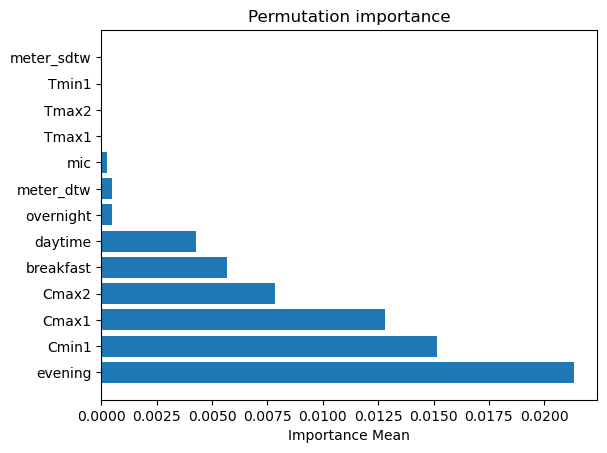

In [104]:
importance_dict = {}
ab = lambda x: abs(x)
for index, key in zip(range(13), result.columns):
    print(f'{key}: ', sum(list(map(abs, r.importances[index::13]))), sum(list(map(abs, r.importances_mean[index::13]))))
    importance_dict[key] = sum(list(map(abs, r.importances_mean[index::13])))
plot_importance(importance_dict)

## only use sdtw and dtw

In [77]:
temp = result[['meter_sdtw','meter_dtw']]
df_2 = pd.DataFrame(np.array(temp).reshape(4225, -1))

In [78]:
# 6:4 and seperate train and test dataset
# only sdtw and dtw 2 features
model, score = train_model(df_2, fdi_4225 , return_model=True)

[06:24:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:24:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:24:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
average_precision_score: 0.9601794340924776
average_recall_score: 0.4246031746031746
average_accuracy_score: 0.9410256410256409
average_roc_auc_score: 0.7113160419665019
average_f1_score: 0.5877822296288417


In [86]:
r = permutation_importance(model, df_2[:evaluation], fdi_4225[:evaluation], n_repeats=2, random_state=0)
for index, key in zip(range(2), temp.columns):
    print(f'{key}: ', sum(list(map(abs, r.importances[index::2]))), sum(list(map(abs, r.importances_mean[index::13]))))

meter_sdtw:  [0.04383886 0.04146919] 0.007701421800948072
meter_dtw:  [0.07227488 0.08175355] 0.007109004739336733


## only use mic

In [87]:
temp = result[['mic']]
df_mic = pd.DataFrame(np.array(temp).reshape(4225, -1))

In [89]:
model, score = train_model(df_mic, fdi_4225 , return_model=True)
r = permutation_importance(model, df_mic[:evaluation], fdi_4225[:evaluation], n_repeats=2, random_state=0, n_jobs=-1)
for index, key in zip(range(1), temp.columns):
    print(f'{key}: ', sum(list(map(abs, r.importances[index::1]))), sum(list(map(abs, r.importances_mean[index::1]))))

[06:31:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:31:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:31:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
average_precision_score: 0.9600892328855171
average_recall_score: 0.998015873015873
average_accuracy_score: 0.9956607495069033
average_roc_auc_score: 0.9967083307260706
average_f1_score: 0.9786357824744338
mic:  [0.0035545  0.00473934] 0.004146

## only use v_value

In [90]:
temp = result[['Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1']]
df_v_value = pd.DataFrame(np.array(temp).reshape(4225, -1))
model, score = train_model(df_v_value, fdi_4225 , return_model=True)
r = permutation_importance(model, df_v_value[:evaluation], fdi_4225[:evaluation], n_repeats=2, random_state=0, n_jobs=-1)
for index, key in zip(range(len(temp.columns)), temp.columns):
    print(f'{key}: ', sum(list(map(abs, r.importances[index::1]))), sum(list(map(abs, r.importances_mean[index::1]))))

[06:34:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:34:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:35:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
average_precision_score: 0.9904640272456363
average_recall_score: 0.8154761904761904
average_accuracy_score: 0.9808678500986193
average_roc_auc_score: 0.9073000750891684
average_f1_score: 0.8942383056196993
Tmax1:  [0.16232227 0.16587678] 0.162

## only use four time

In [91]:
temp = result[['overnight', 'breakfast', 'daytime', 'evening']]
df_four_time = pd.DataFrame(np.array(temp).reshape(4225, -1))
model, score = train_model(df_four_time, fdi_4225 , return_model=True)
r = permutation_importance(model, df_four_time[:evaluation], fdi_4225[:evaluation], n_repeats=2, random_state=0, n_jobs=-1)
for index, key in zip(range(len(temp.columns)), temp.columns):
    print(f'{key}: ', sum(list(map(abs, r.importances[index::1]))), sum(list(map(abs, r.importances_mean[index::1]))))

[06:45:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:45:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:45:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
average_precision_score: 0.9977628635346756
average_recall_score: 0.8412698412698413
average_accuracy_score: 0.9840236686390532
average_roc_auc_score: 0.9205254155976889
average_f1_score: 0.9125585039483722
overnight:  [0.04265403 0.04383886] 0

no origin data
Saving figure Permutation importance: XGBoost: permutation importance


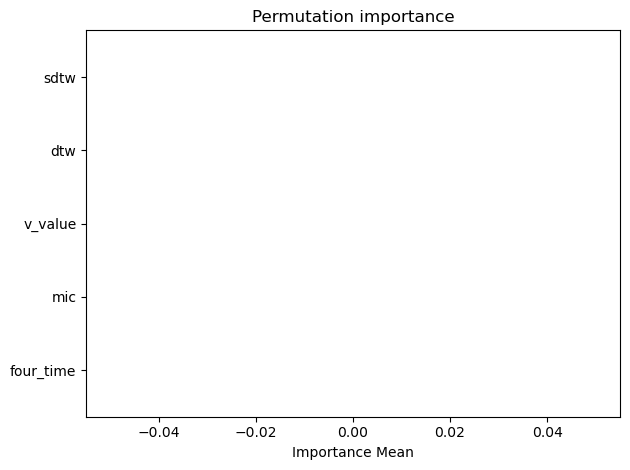

In [46]:
TITLE = "XGBoost: permutation importance"
get_permutation_importance(model, df[:evaluation], fdi_4225[:evaluation], title= TITLE, origin=False, save=True)

In [44]:
1

1